## Importing Libraries

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

## Load and Inspect the Data

In [122]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [123]:
df.shape

(1338, 7)

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [125]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Exploratory Data Analysis (EDA)

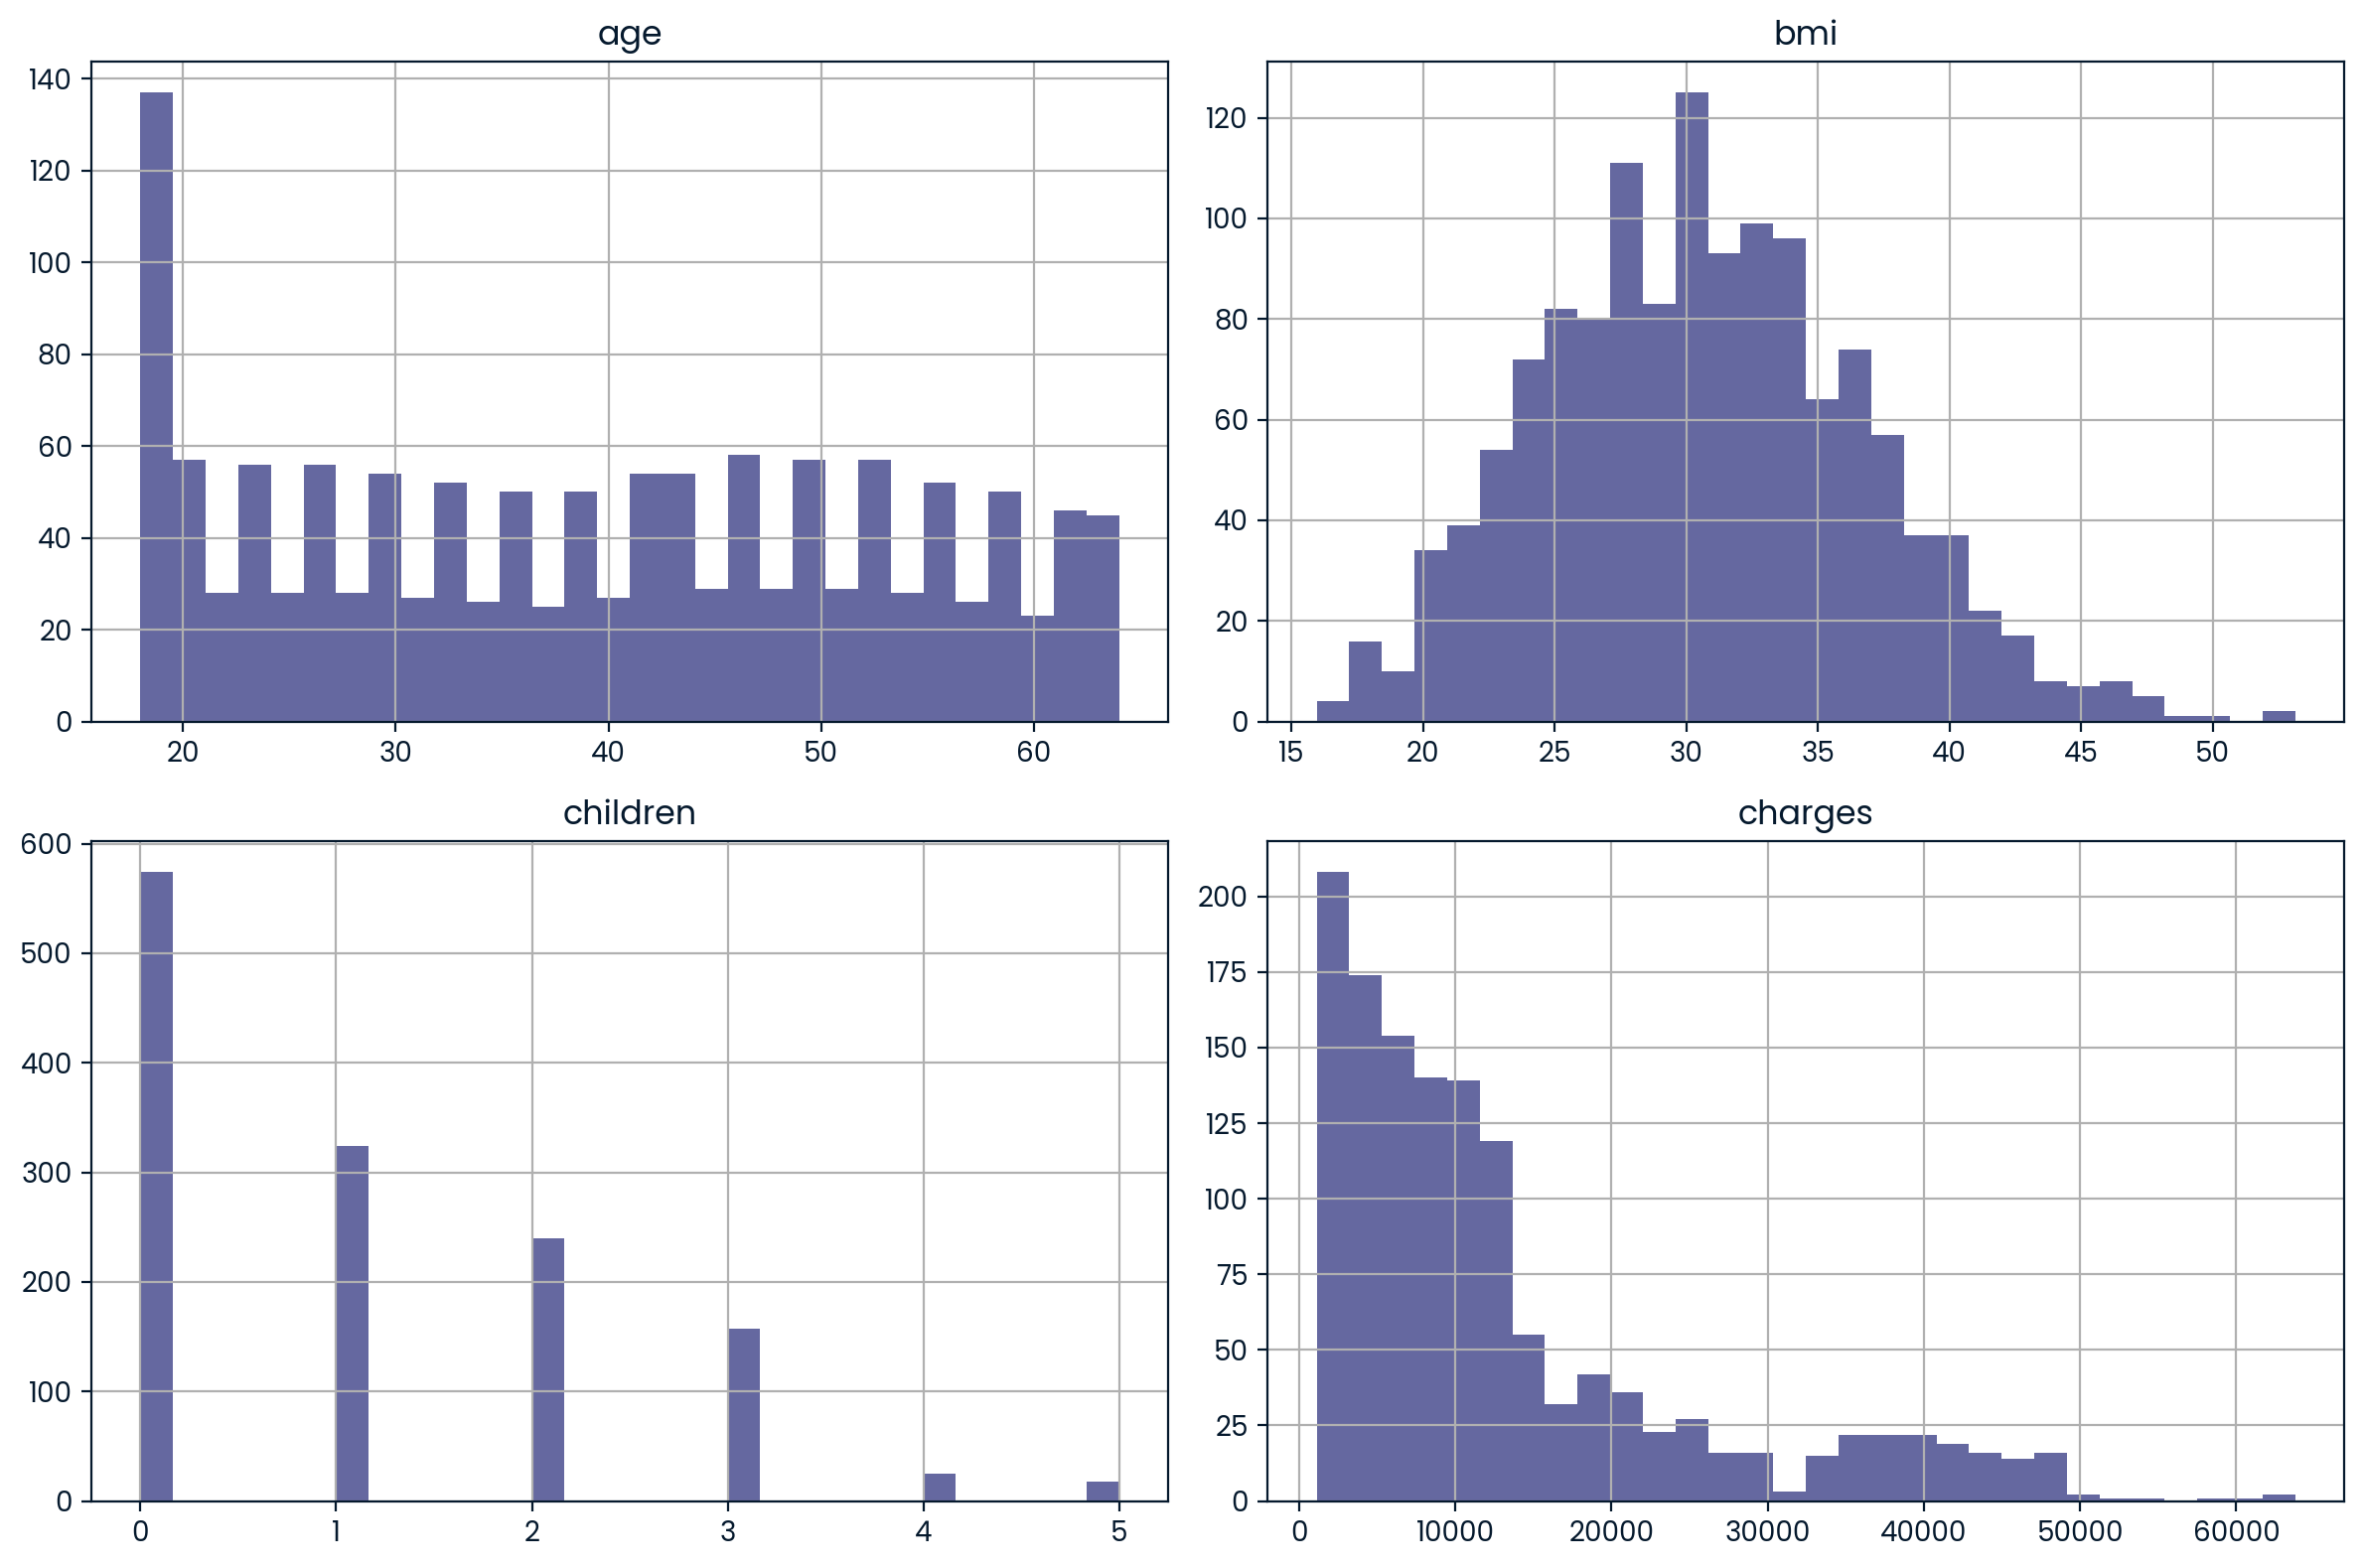

In [126]:
# Histogram for continuous features
df.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

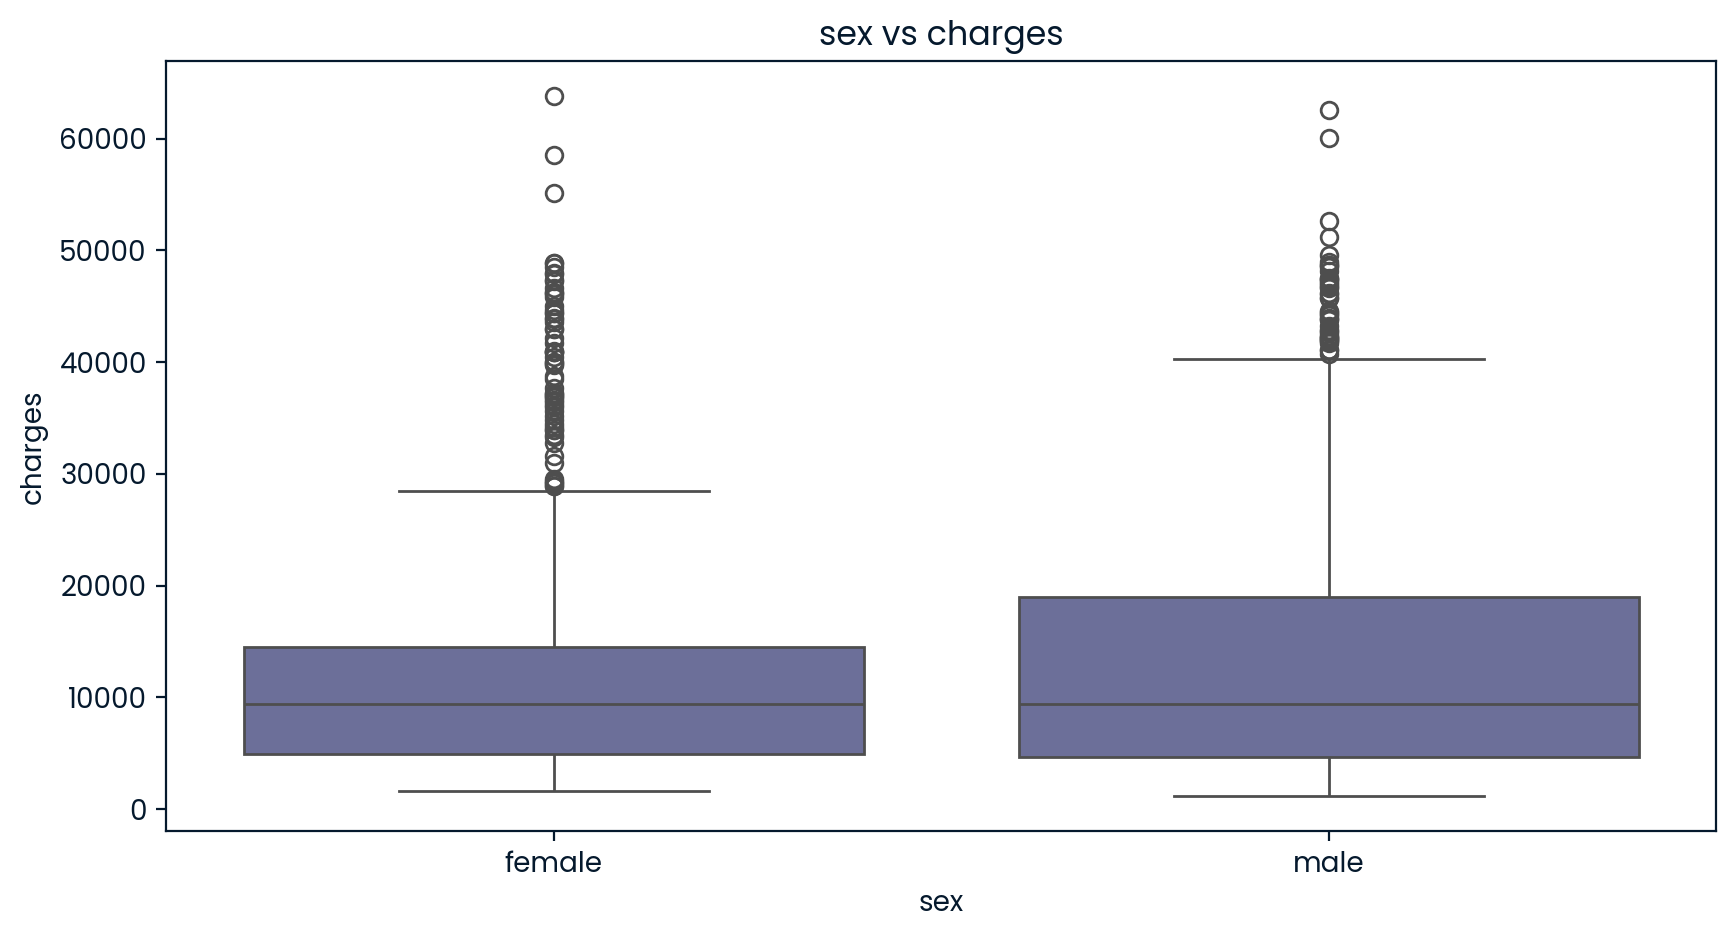

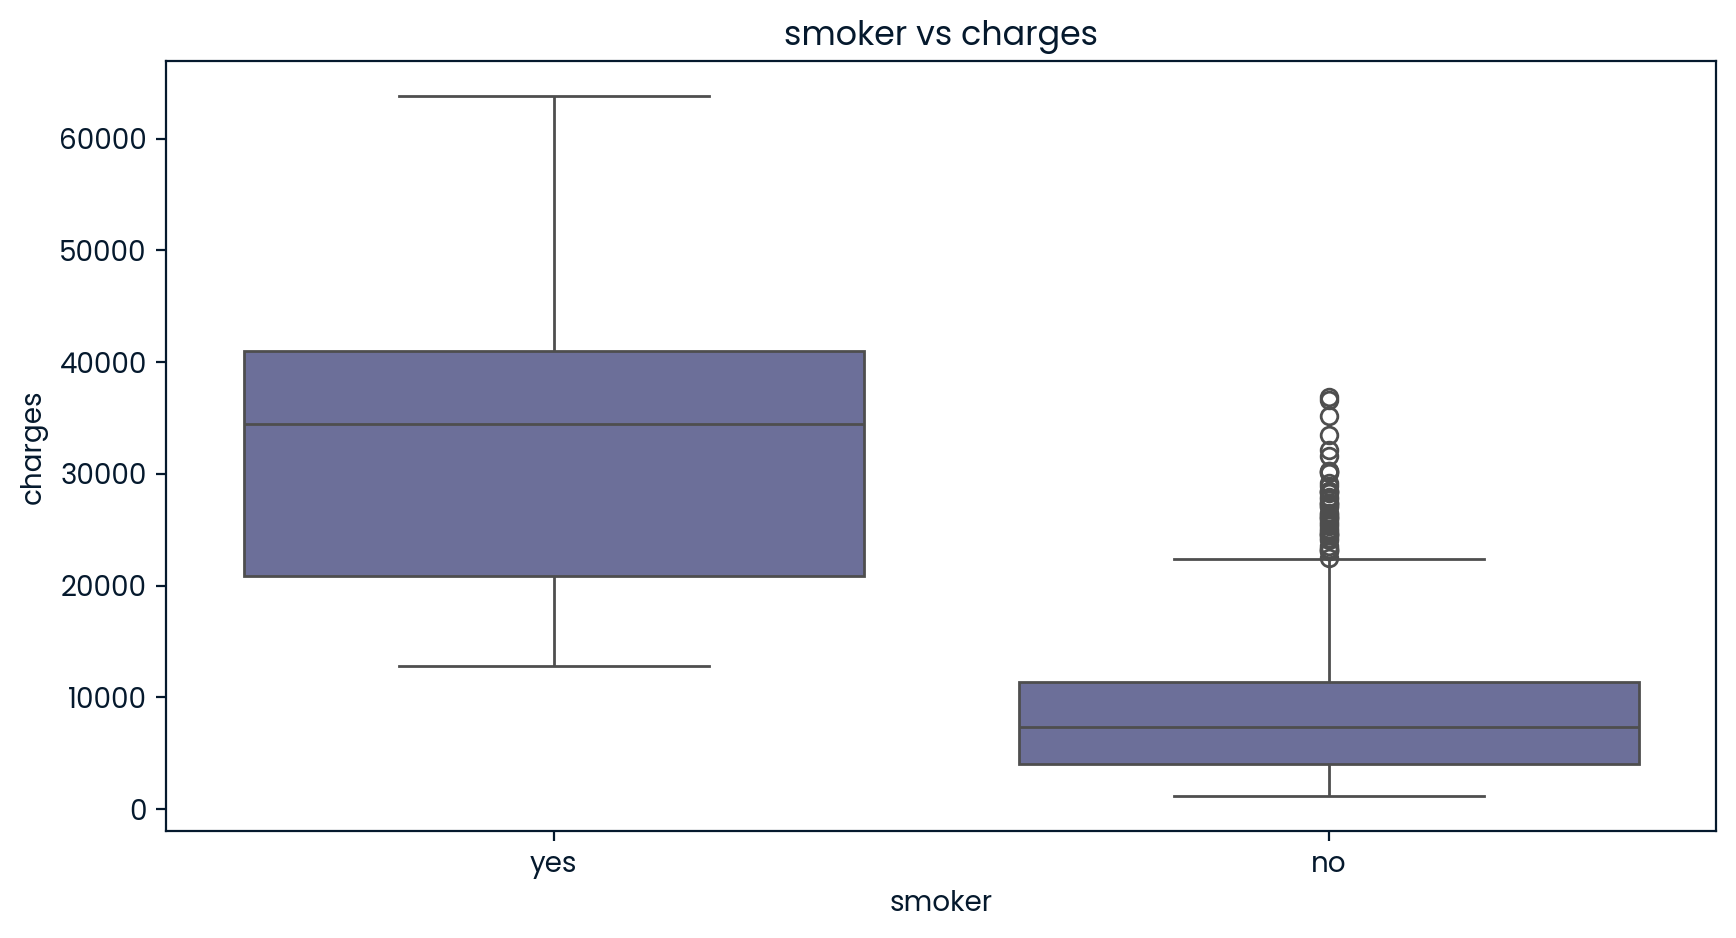

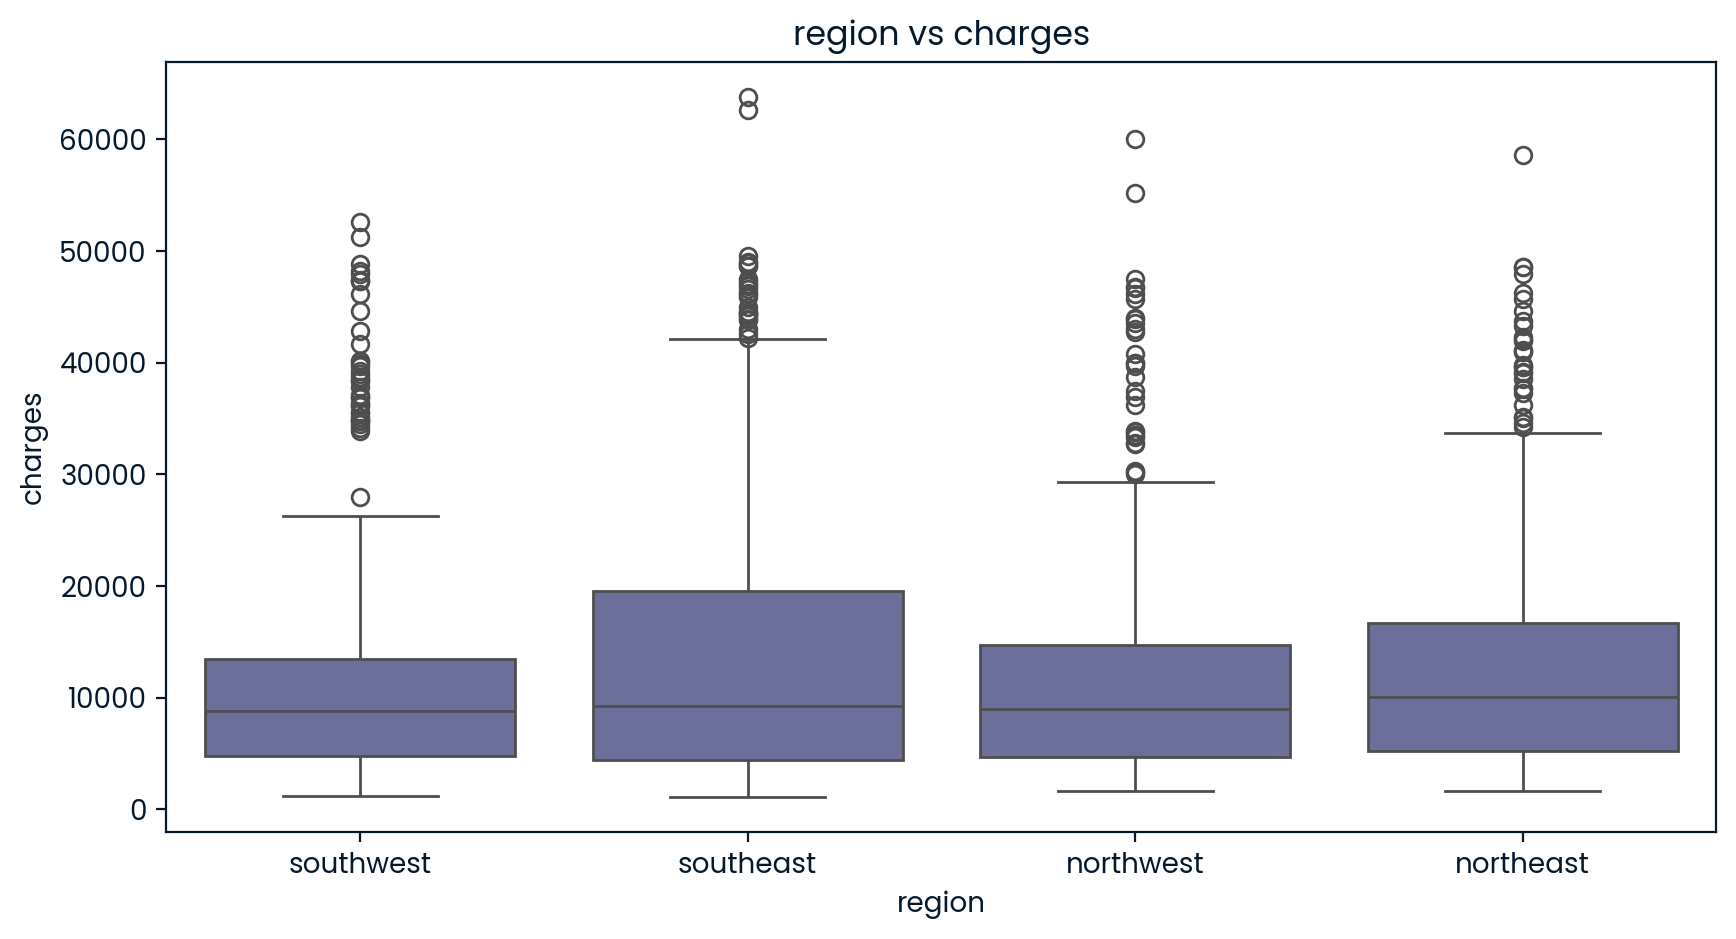

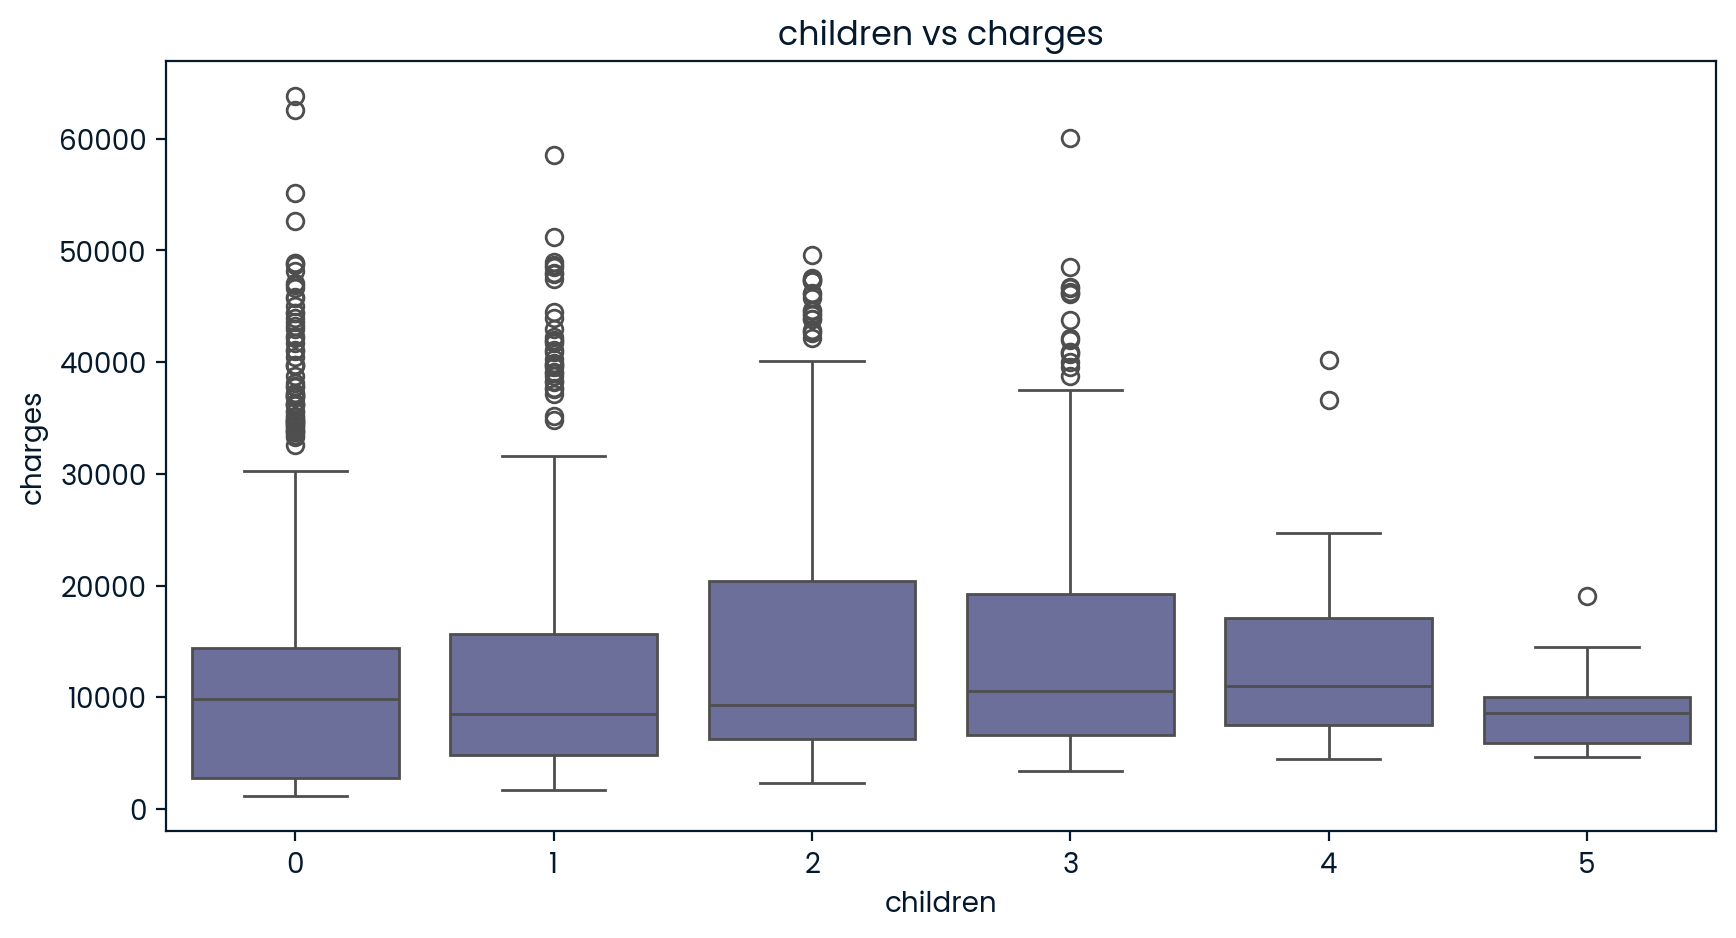

In [127]:
# Box Plots for Categorical Features vs Target
for col in ['sex', 'smoker', 'region', 'children']:
    plt.figure(figsize=(10,5))
    sns.boxplot(x=col, y='charges', data=df)
    plt.title(f'{col} vs charges')
    plt.show()

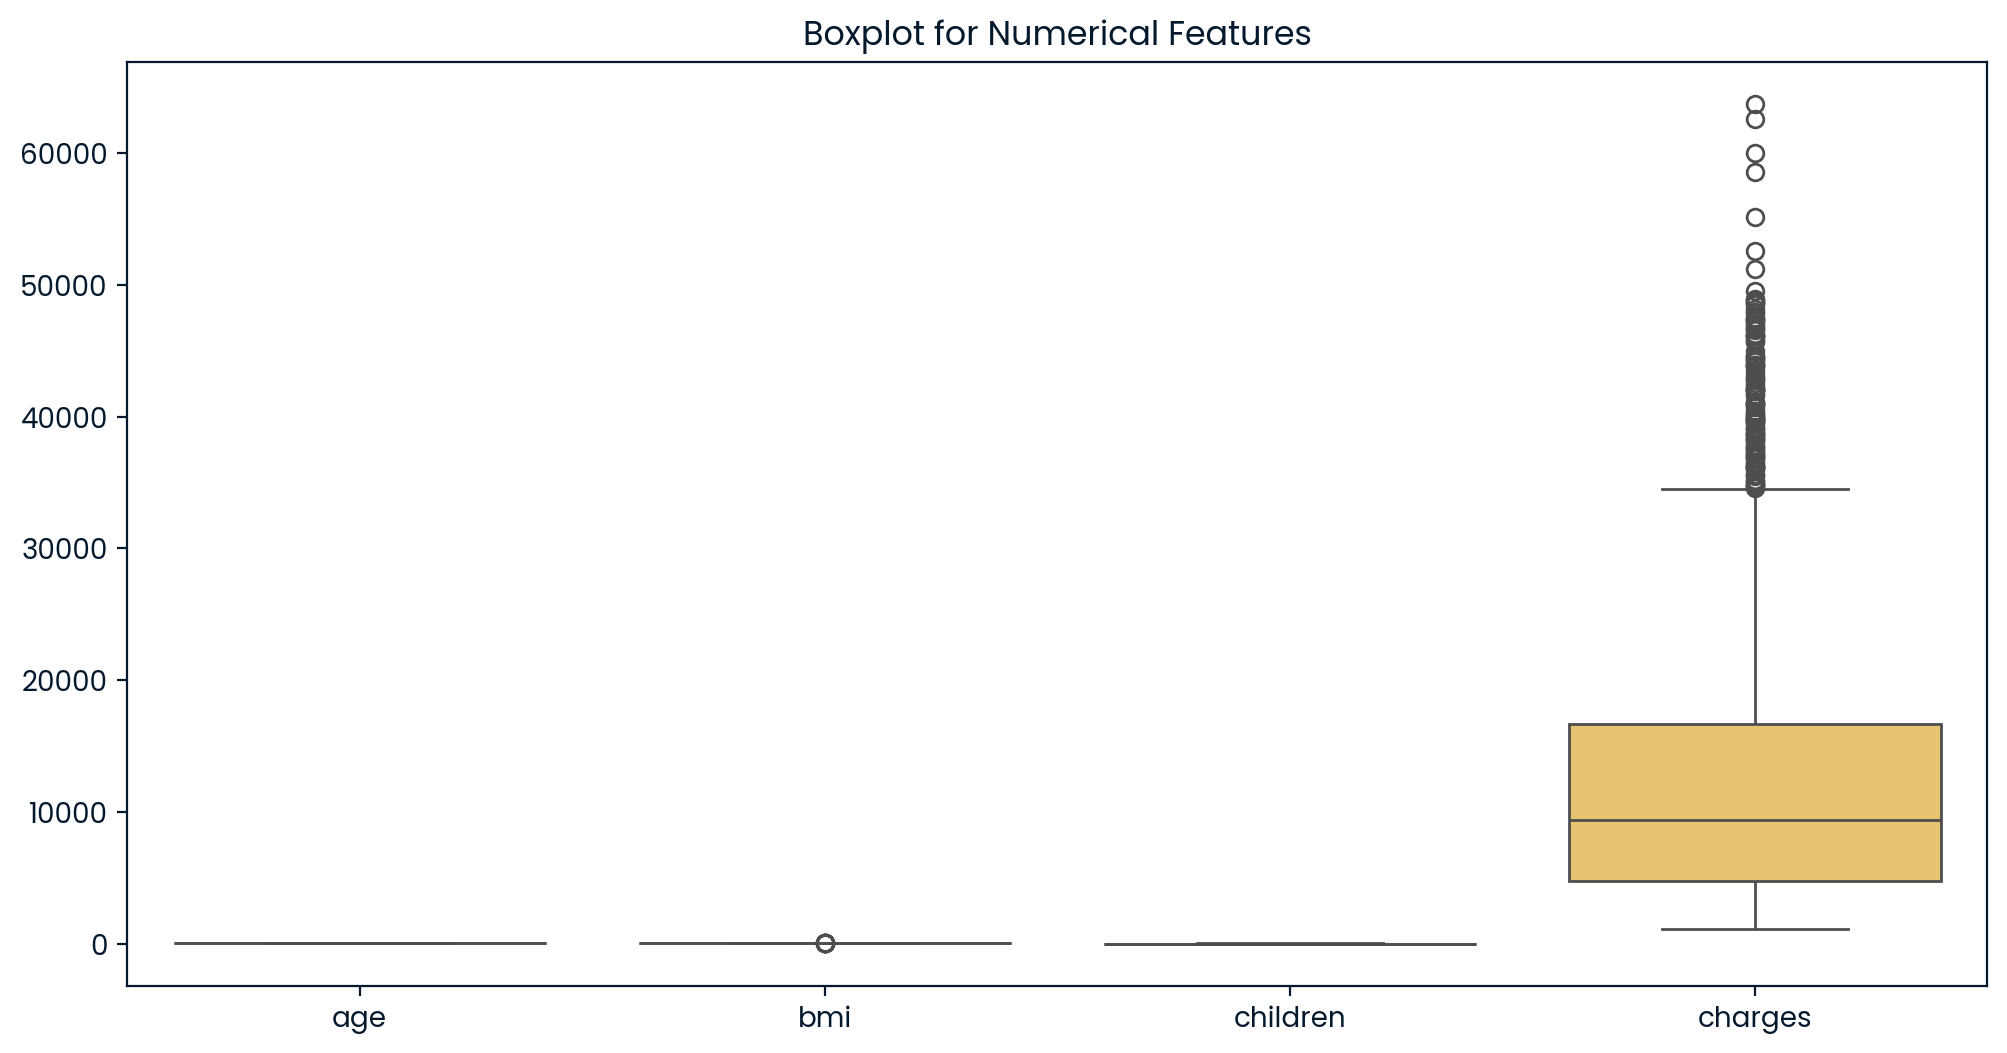

In [128]:
# Boxplot for Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['age', 'bmi', 'children', 'charges']])
plt.title("Boxplot for Numerical Features")
plt.show()

<Axes: xlabel='bmi', ylabel='charges'>

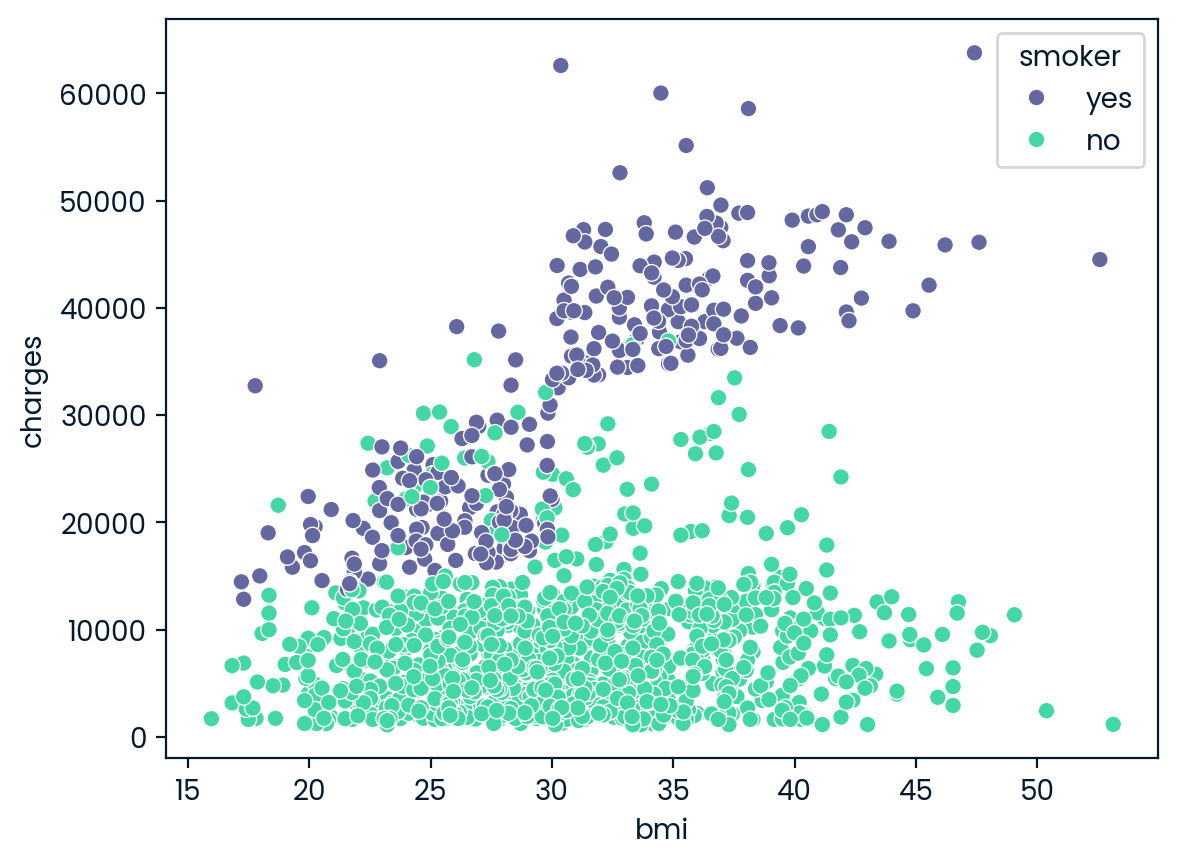

In [129]:
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df)

### Insights:
- Smokers with high bmi are paying the most

<Axes: xlabel='age_bins', ylabel='charges'>

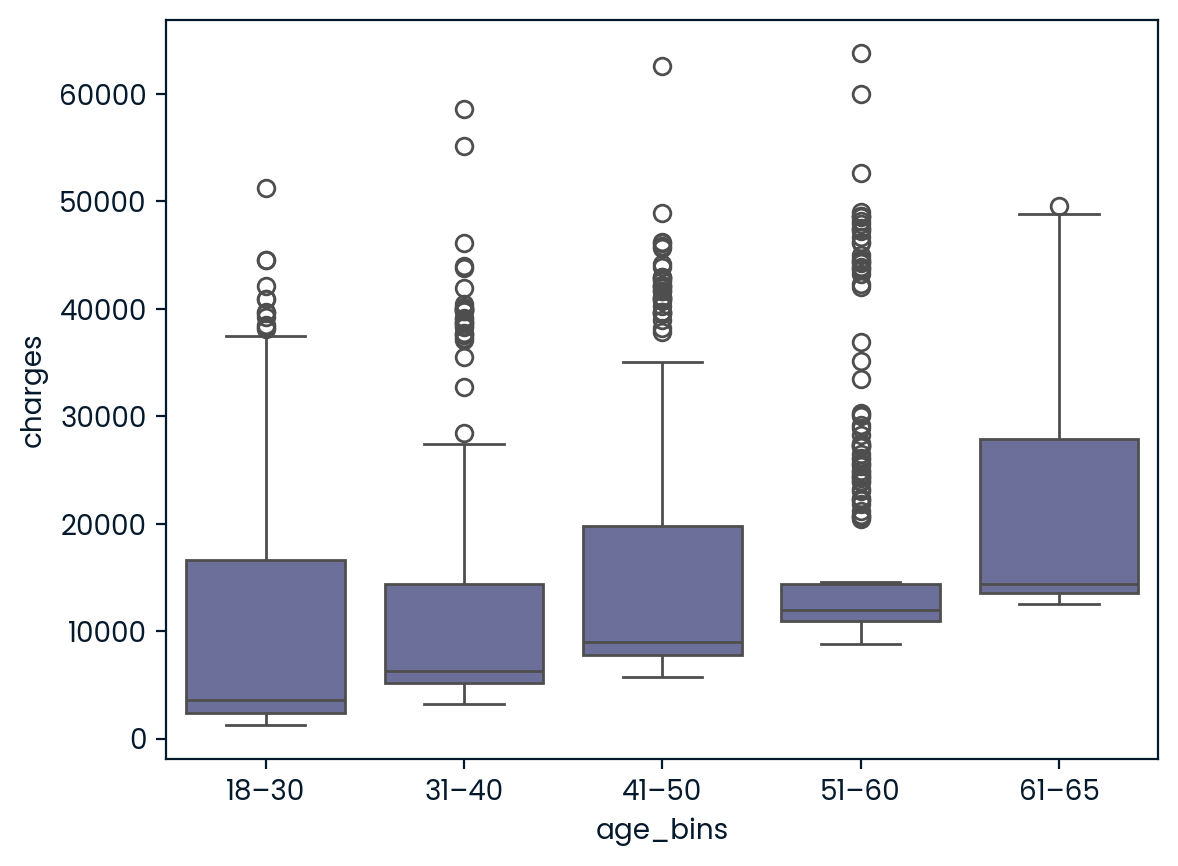

In [130]:
bins=[18,30,40,50,60,65]
labels=['18–30','31–40','41–50','51–60','61–65']
df['age_bins']=pd.cut(df['age'], bins=bins, labels=labels)
sns.boxplot(x='age_bins', y='charges', data=df)

Insight:
- Age groups show rising cost trend
  
dropping age_bins after eda

In [131]:
df.drop('age_bins', axis=1, inplace=True)

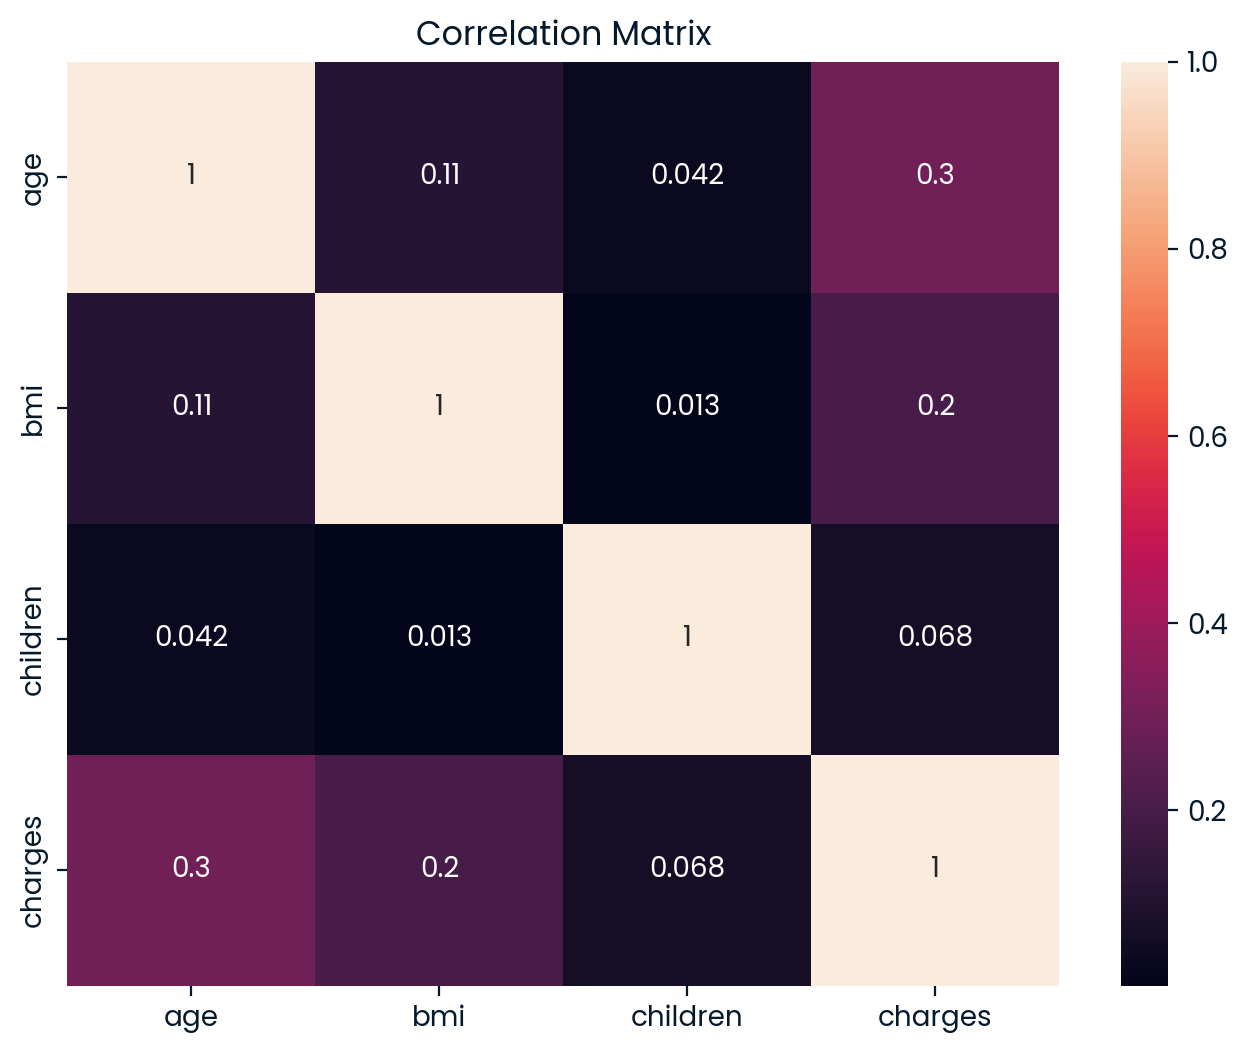

In [132]:
# Correlation Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title("Correlation Matrix")
plt.show()

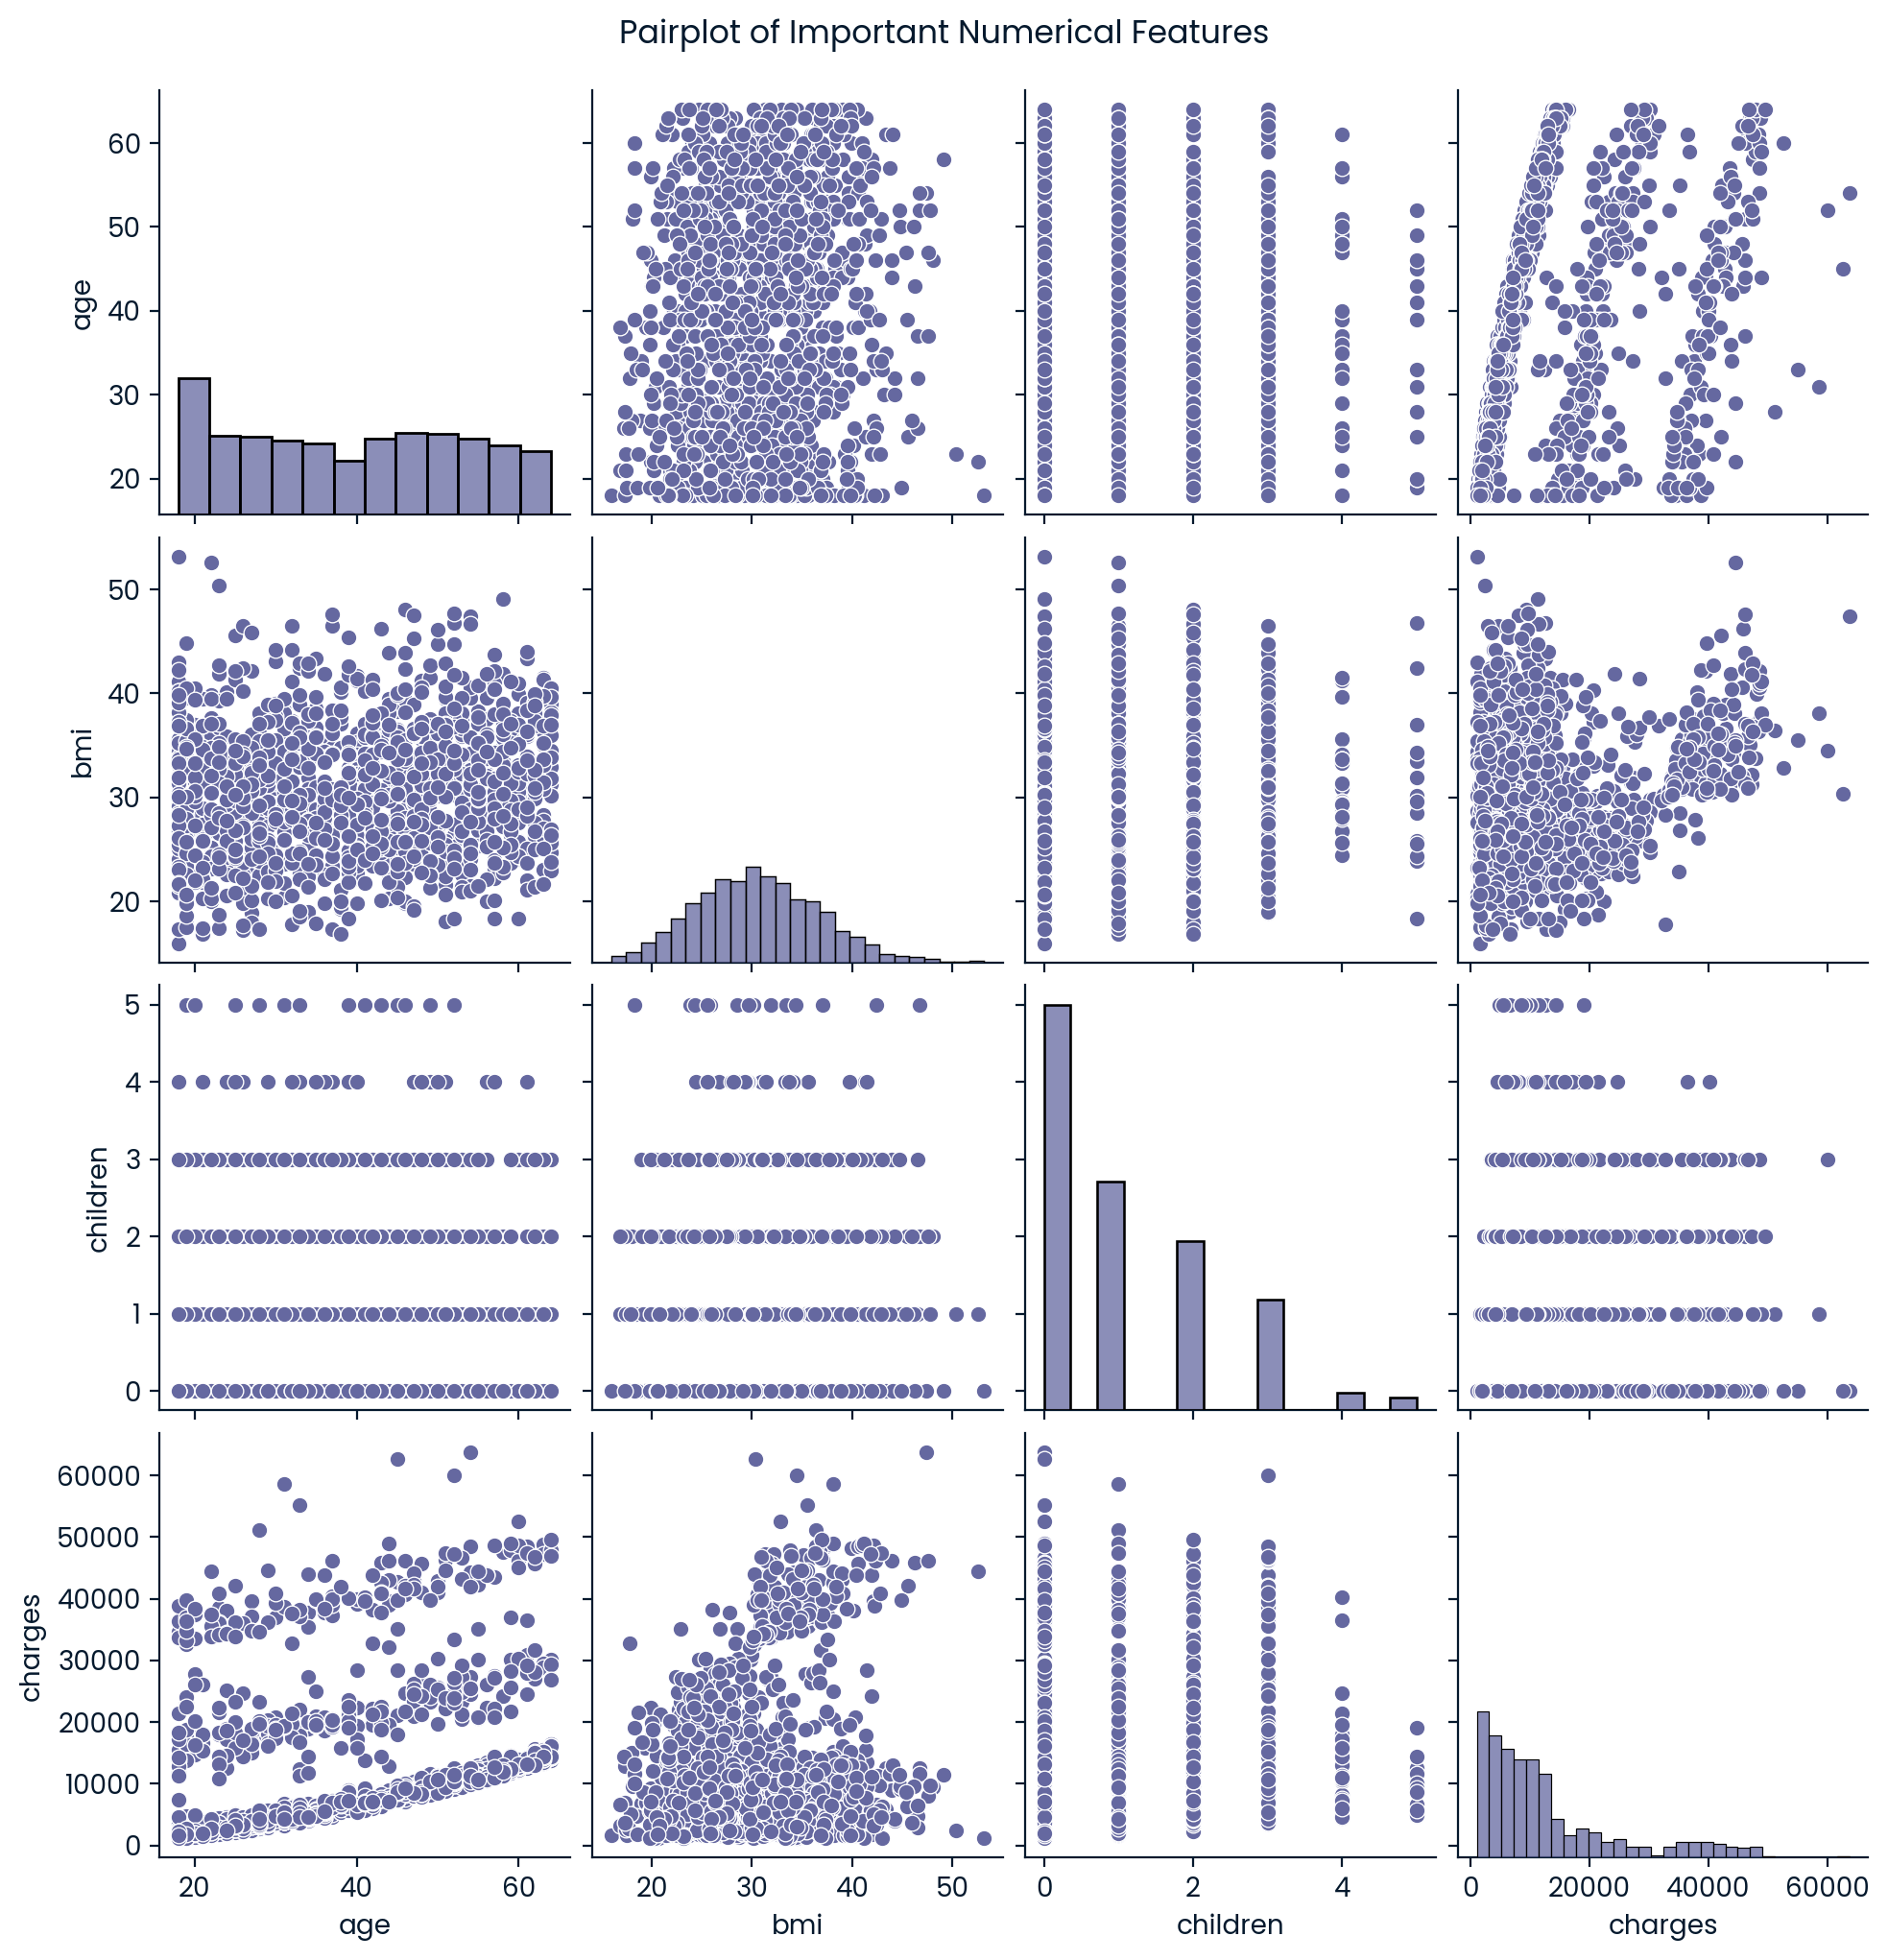

In [133]:
# Selecting most relevant features based on heatmap
important_cols = ['age', 'bmi', 'children', 'charges']

sns.pairplot(df[important_cols])
plt.suptitle("Pairplot of Important Numerical Features", y=1.02)
plt.show()

Insights from pairplots
- Charges increase with age.
- Higher BMI can lead to higher charges.
- Number of children has little effect on charges.
- Charges are right-skewed with some very high values.

## Applying log transformation to Charges as it is right skewed

<Axes: xlabel='charges', ylabel='Count'>

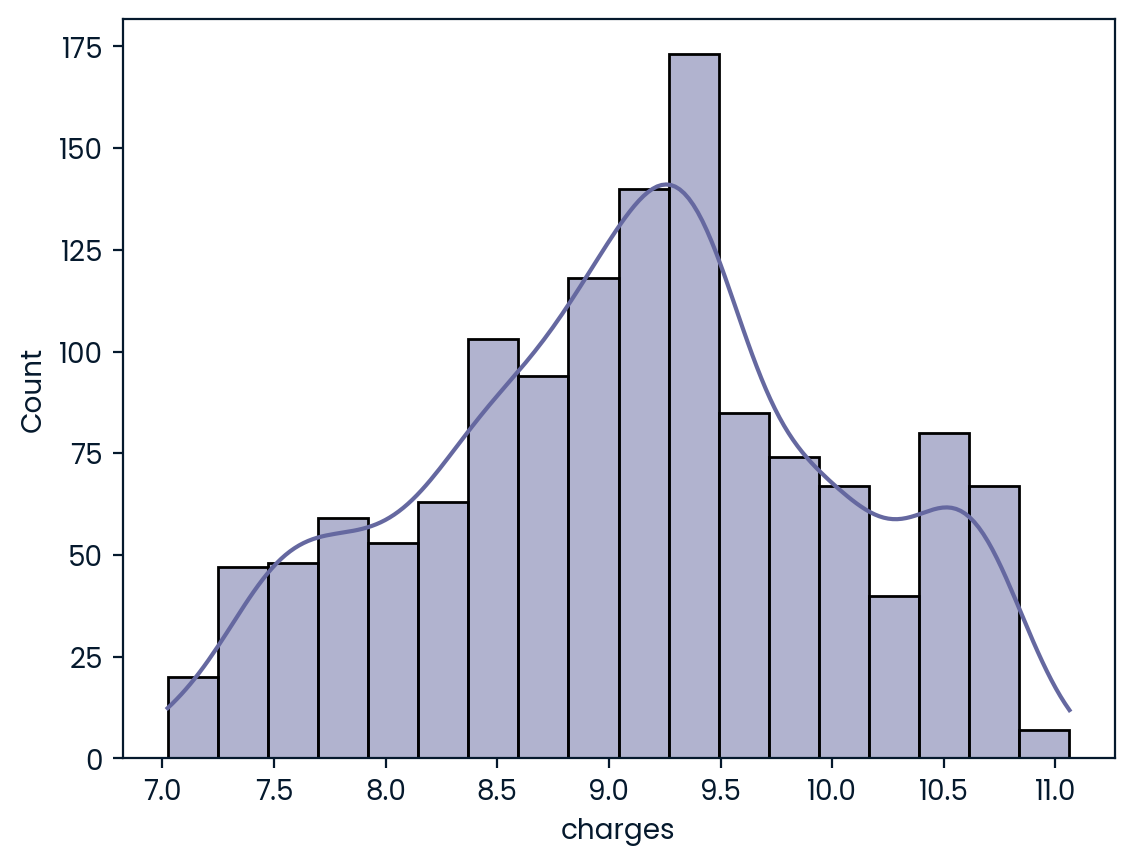

In [134]:
df['charges'] = np.log1p(df['charges'])
sns.histplot(x='charges', data=df, kde=True)

In [135]:
X=df.iloc[:,0:6]
y=df['charges']

## Checking missing values

In [136]:
X.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

No missing vals ✔️

## Splitting Data

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocessing

In [138]:
# Separate categorical and numerical columns
cat_cols = ['sex', 'smoker', 'region']
num_cols = ['age', 'bmi', 'children']

# Preprocessor
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
])

## Linear Regression Model (from Scratch)

In [139]:
class LinearRegression:
    def __init__(self):
        self.coef_=None
        self.intercept_=None
        
    def fit(self, X_train, y_train):
        X_train=np.insert(X_train, 0,1, axis=1)
        beta_vals=np.linalg.inv(np.dot(X_train.T, X_train)).dot(X_train.T).dot(y_train)
        self.coef_=beta_vals[1:]
        self.intercept_=beta_vals[0]
        
    def predict(self, X_test):
        return self.intercept_ + np.dot(X_test,self.coef_ )

## Building Pipeline

In [140]:
# Full pipeline
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('model', LinearRegression())
])

## Train the Model

In [141]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['sex', 'smoker', 'region']),
                                                 ('scaler', StandardScaler(),
                                                  ['age', 'bmi',
                                                   'children'])])),
                ('model',
                 <__main__.LinearRegression object at 0x7f08f0f07e20>)])

## Make Predictions and Evaluate

In [142]:
y_pred = pipeline.predict(X_test)

In [143]:
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print("R² Score:", r2)
print("RMSE:", rmse)

R² Score: 0.8047410791393007
RMSE: 0.4189380724560716


## Checking if overfitting or underfitting occurs 

In [144]:
r2_score(y_train, pipeline.predict(X_train))

0.7572393386868164

### Model predicts slightly better to unseen data than to training data
- There is no overfitting 
- There is no underfitting

## Cross Validation

In [145]:
np.mean(cross_val_score(pipeline, X, y, cv=5, scoring='r2'))

0.763792373248244

## Visualization – Actual vs Predicted

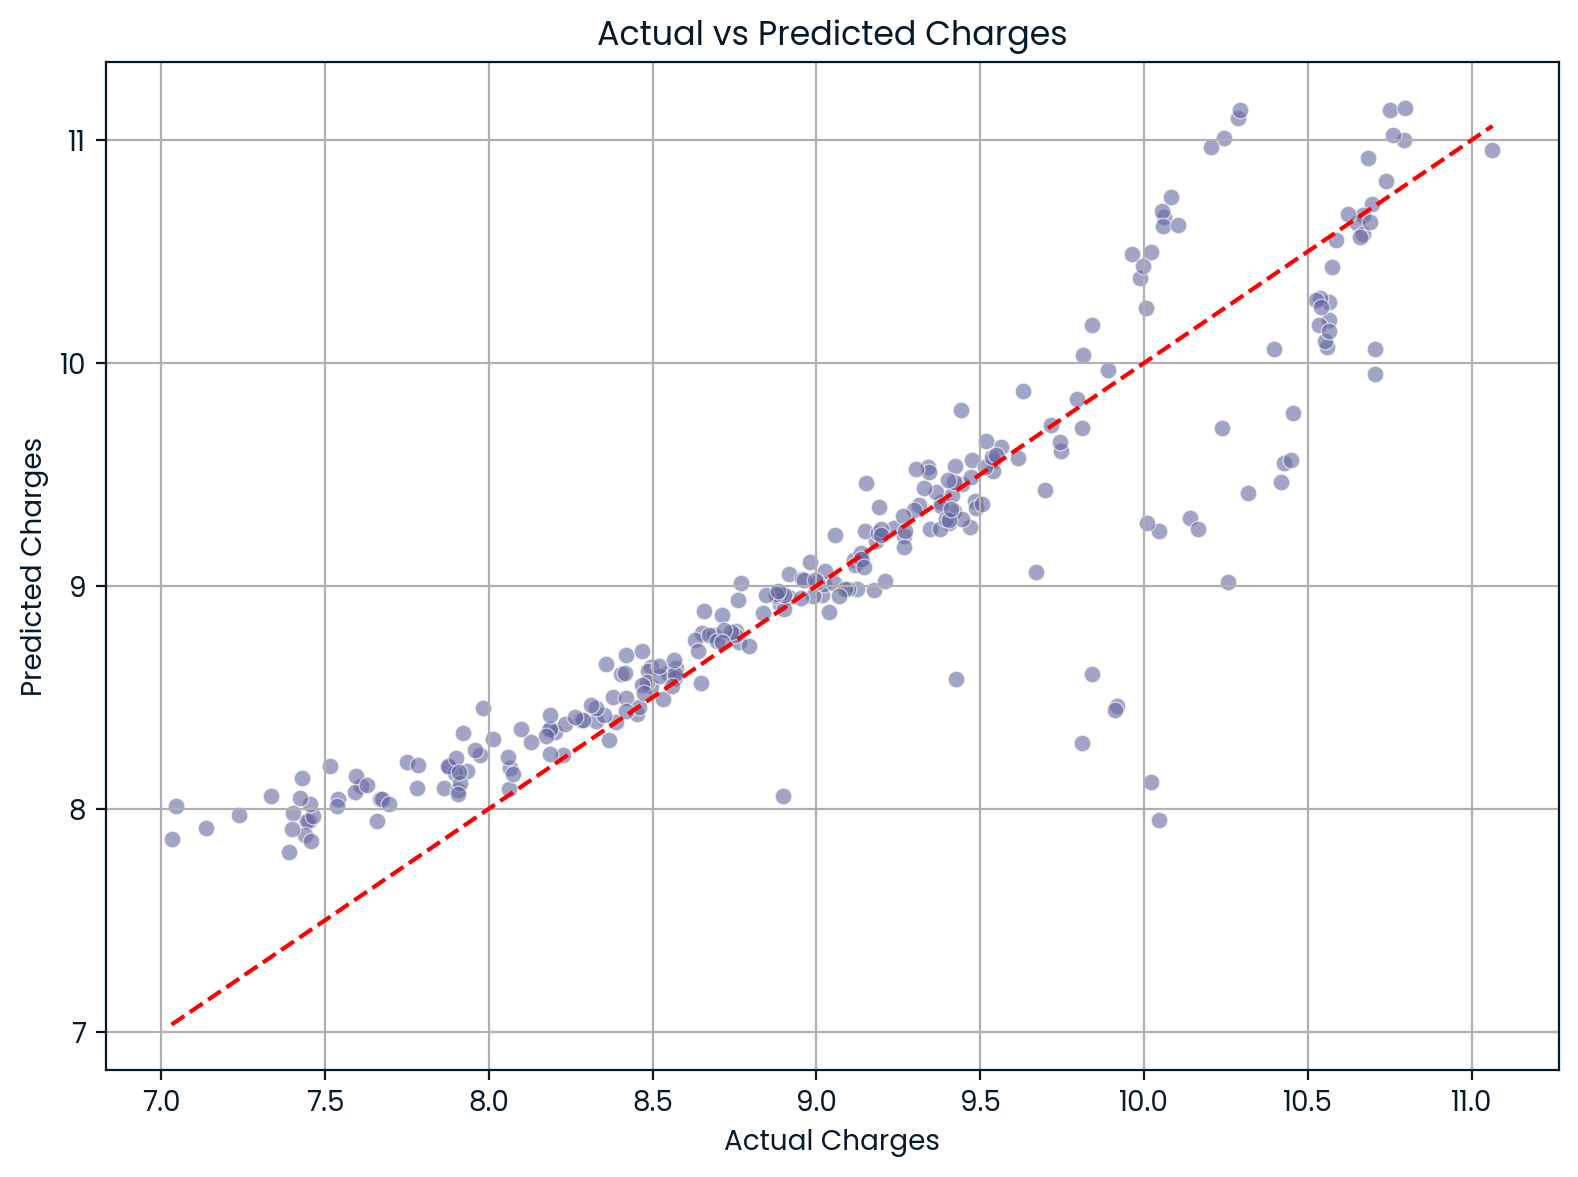

In [146]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted Charges")
plt.grid(True)
plt.tight_layout()
plt.show()

## Comparing coefficients (which feature affects the target the most)

In [147]:
coefficients= pipeline.named_steps['model'].coef_

In [148]:
coefficients

array([-0.07432119,  1.55151945, -0.05640208, -0.13602746, -0.12252663,
        0.48164304,  0.08214583,  0.11232776])

In [162]:
feature_names = pipeline.named_steps['preprocess'].get_feature_names_out()

In [163]:
feature_names

array(['onehot__sex_male', 'onehot__smoker_yes',
       'onehot__region_northwest', 'onehot__region_southeast',
       'onehot__region_southwest', 'scaler__age', 'scaler__bmi',
       'scaler__children'], dtype=object)

In [164]:
coef_df= pd.DataFrame({
    'feature' : feature_names,
    'coefficient' : coefficients
}).sort_values(by='coefficient', ascending=False)

In [154]:
coef_df

,feature,coefficient
1,onehot__smoker_yes,1.551519
5,scaler__age,0.481643
7,scaler__children,0.112328
6,scaler__bmi,0.082146
2,onehot__region_northwest,-0.056402
0,onehot__sex_male,-0.074321
4,onehot__region_southwest,-0.122527
3,onehot__region_southeast,-0.136027


In [157]:
coef_df.dtypes

feature         object
coefficient    float64
dtype: object

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'onehot__smoker_yes'),
  Text(1, 0, 'scaler__age'),
  Text(2, 0, 'scaler__children'),
  Text(3, 0, 'scaler__bmi'),
  Text(4, 0, 'onehot__region_northwest'),
  Text(5, 0, 'onehot__sex_male'),
  Text(6, 0, 'onehot__region_southwest'),
  Text(7, 0, 'onehot__region_southeast')])

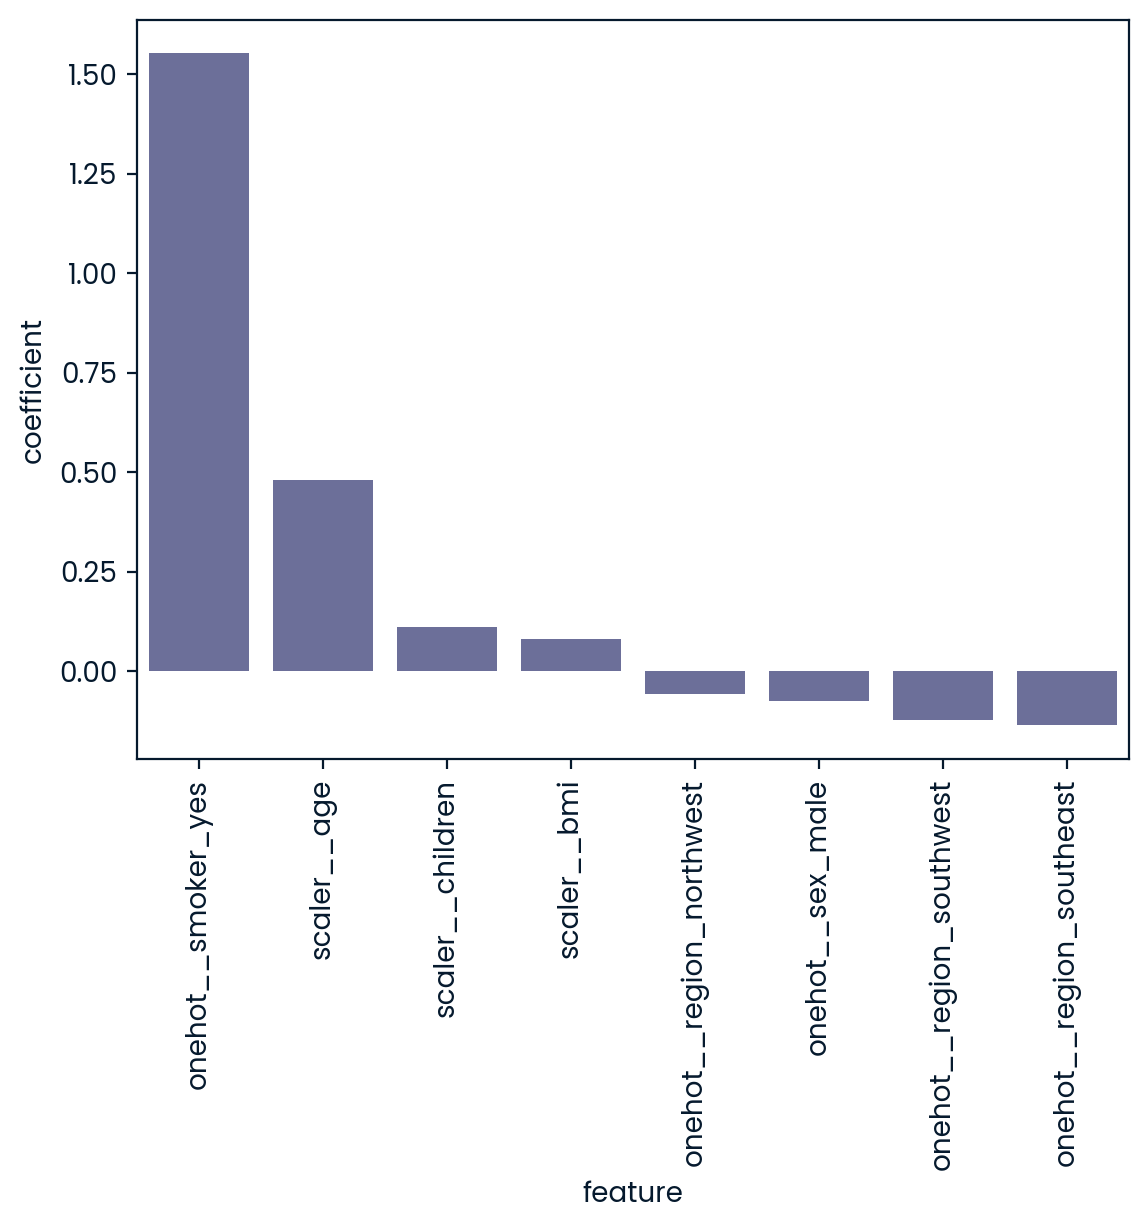

In [166]:
sns.barplot(x='feature', y='coefficient', data=coef_df)
plt.xticks(rotation=90)